In [ ]:
from google.colab import drive
drive.mount('/content/drive')
ROOT='''/content/drive/MyDrive/Colab Notebooks/googledrive/imageCaptioning'''

Mounted at /content/drive


In [ ]:
!pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 5.9 MB/s eta 0:00:00


inlab
['git', 'ofa', 'blip', 'clipcap', 'microsoft_api']
nTrials: machine (ALL): 600  git: 120  ofa: 120  blip: 120  clipcap: 120  microsoft_api: 120  
bootstraptime 600 sampletime 300
bootstraptime 120 sampletime 60
bootstraptime 120 sampletime 60
bootstraptime 120 sampletime 60
bootstraptime 120 sampletime 60
bootstraptime 120 sampletime 60
mturk
['git', 'ofa', 'blip', 'clipcap', 'microsoft_api']
nTrials: machine (ALL): 4100  git: 820  ofa: 820  blip: 820  clipcap: 820  microsoft_api: 820  
bootstraptime 4100 sampletime 2050
bootstraptime 820 sampletime 410
bootstraptime 820 sampletime 410
bootstraptime 820 sampletime 410
bootstraptime 820 sampletime 410
bootstraptime 820 sampletime 410
Corrected Alpha: 0.002777777777777778
Corrected P Values: [np.float64(0.54547497978705), np.float64(2.9763443498186716e-17), np.float64(0.011353209134386963), np.float64(0.011004730123631812), np.float64(1.0), np.float64(0.19316293900845194), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float

<ipython-input-7-98af3950d298>:387: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


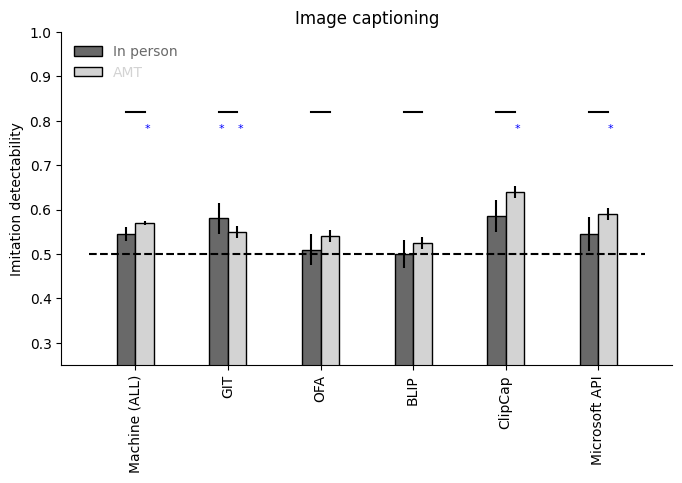

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
from colour import Color
import seaborn as sn
import pandas as pd
from matplotlib.patches import Rectangle

import pingouin as pg
from scipy import stats
import random
import math
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests
XIAOROOT='/home/liuxiao/TuringGithub/XiaoData/Rebuttal_Figures/R3.7-Bonferroni-Correction/'

def outputIconForStats(pval):
    if pval <= 0.05:
        icon = '*'
    else:
        icon = ' '
    return icon

def ConvertDictToDataFrame(datadict):
    #data = {'col_1': [3, 2, 1, 0], 'col_2': ['a', 'b', 'c', 'd']}
    X = []
    Y = []
    for key in datadict.keys():
        for ele in datadict[key]:
            X.append(ele)
            Y.append(key)

    data = {'X': X, 'group': Y}
    df = pd.DataFrame.from_dict(data)
    return df

def ComputeStats_group1(d_cond):
    #compare against chance
    r_data = np.random.choice([0, 1], size=len(d_cond), p=[.5, .5])
    result = pg.ttest(d_cond, r_data, correction=True)
    pval = result.at['T-test',"p-val"]
    Tval = result.at['T-test',"T"]
    dof = math.floor(result.at['T-test',"dof"])
    icon = outputIconForStats(pval)
    return icon, pval, Tval, dof

def ComputeStats_group2(data_d1, data_d2):
    result = pg.ttest(data_d1, data_d2, correction=True)

    # reporting format in Turing project (p < 10−15, two-tailed t-test, t = 8.5, df = 478)
    pval = result.at['T-test',"p-val"]
    Tval = result.at['T-test',"T"]
    dof = math.floor(result.at['T-test',"dof"])
    icon = outputIconForStats(pval)
    return icon, pval, Tval, dof

def ComputeStats_group3(data_dict):
    df = ConvertDictToDataFrame(data_dict)
    #print(df)
    mod = ols('X ~ group', data=df).fit()
    aov_table = sm.stats.anova_lm(mod, typ=2)

    #A one-way ANOVA revealed that there [was or was not] a statistically significant difference in [dependent variable]
    #between at least two groups (F(between groups df, within groups df) = [F-value], p = [p-value]).
    BetweenGP_df = aov_table.df.group
    WithinGP_df = aov_table.df.Residual
    Fval = aov_table.F.group
    pval = aov_table['PR(>F)'].group
    icon = outputIconForStats(pval)
    return icon, BetweenGP_df, WithinGP_df, Fval, pval

def displayStats_group12(pval, Tval, dof):
    if pval < 0.05:
        print('There is difference between data1 and data2.')
        if pval > 0.01 and pval < 0.05:
            print("(p < 0.05, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
        elif pval > 0.001 and pval <= 0.01:
            print("(p < 0.01, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
        elif pval > 0.0001 and pval <= 0.001:
            print("(p < 0.001, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
        else:
            print("(p < 0.0001, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
    else:
        print('There is NO difference between data1 and data2.')
        print("(p > 0.05, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")


def displayStats_group3(BetweenGP_df, WithinGP_df, Fval, pval):
    print("F(" + str(BetweenGP_df) + ", " + str(WithinGP_df) + ") = " + str(Fval) +", p-val=" + str(pval))


def boostrap(data1, data2):
    import random
    import math
    store = []
    sample_mean = []
    if len(data1) < len(data2):
        SampleTimes = math.ceil(len(data1)/2)
        BootstrapTimes = len(data1)
    else:
        SampleTimes = math.ceil(len(data2)/2)
        BootstrapTimes = len(data2)

    print("bootstraptime",BootstrapTimes,"sampletime",SampleTimes)
    for i in range(BootstrapTimes):
        y1 = random.sample(data1, SampleTimes)
        #print(y1)
        y2 = random.sample(data2, SampleTimes)
        #print(y2)
        y_comb = y1+y2
        #print(y_comb)
        sample_mean.append(np.mean(np.array(y_comb), axis=0))

    stdval = np.std(np.array(sample_mean), axis=0)
    return stdval

def ConcatData(data1, data2):
    import random
    import math

    #print(data1)
    #print(data2)
    if len(data1) < len(data2):
        BootstrapTimes = len(data1)
    else:
        BootstrapTimes = len(data2)

    #print(BootstrapTimes)
    y1 = random.sample(data1, BootstrapTimes)
    #print(y1)
    y2 = random.sample(data2, BootstrapTimes)
    #print(y2)
    y_comb = y1+y2
    y_comb = np.array(y_comb)
    return y_comb


def ComputeBarStdConfMat(contents):
    modelist = ['git', 'ofa', 'blip', 'clipcap', 'microsoft_api']
    print(modelist)

    #initialize matrix of absolute counts
    result = {'human':0, 'countH':0, 'machine':0, 'countM': 0, 'result_H':[], 'result_M':[]}
    for modelname in modelist:
        result[modelname] = 0
        result['count_'+modelname] = 0
        result['result_'+modelname]=[]
    #print(result)

    # Iterating over keys
    for trialid in contents:
        trialinfor = contents[trialid]['trialData']

        if trialinfor['groundtruth'] == 'human':
            result['countH'] = result['countH'] + 1
            if trialinfor['response_speaker'] == trialinfor['groundtruth']:
                result['human'] = result['human'] + 1
                result['result_H'].append(1)
            else:
                result['result_H'].append(0)

        else:
            result['countM'] = result['countM'] + 1
            if trialinfor['response_speaker'] == trialinfor['groundtruth']:
                result['machine'] = result['machine'] + 1
                result['result_M'].append(1)
            else:
                result['result_M'].append(0)

            modelname = trialinfor['machine_groundtruth']
            result['count_'+modelname] = result['count_'+modelname] + 1
            if trialinfor['response_speaker'] == trialinfor['groundtruth']:
                result[modelname] = result[modelname] + 1
                result['result_' + modelname].append(1)
            else:
                result['result_' + modelname].append(0)

    #print(result)
    ## Xiao: Print Statistics START
    tmp_ntrials = []
    tmp_str_ntrials = ""
    for _ in result.keys():
      if "count" not in _ or "countH" in _:
        continue
      tmp_str_ntrials += (_.replace('countM','machine (ALL)').replace("count_","") +": "+str(result[_])+"  ")
    print("nTrials:", tmp_str_ntrials)
    ## Xiao: Print Statistics END

    #compute confusion matrix
    result_conf_mat = np.zeros((2+len(modelist),2),'float32')
    result_conf_mat[0][0] = result['human']/result['countH']
    result_conf_mat[0][1] = (result['countH'] - result['human'])/result['countH']
    result_conf_mat[1][0] = (result['countM'] - result['machine'])/result['countM']
    result_conf_mat[1][1] = result['machine']/result['countM']

    for i, modelname in enumerate(modelist):
        result_conf_mat[i+2][0] = (result['count_'+modelname] - result[modelname])/result['count_'+modelname]
        result_conf_mat[i+2][1] = result[modelname]/result['count_'+modelname]

    result_conf_mat = np.around(result_conf_mat, decimals=2)

    stdmodelist = ['M', 'git', 'ofa', 'blip', 'clipcap', 'microsoft_api']
    modelist_stats = ['Machine', 'GIT', 'OFA', 'BLIP', 'ClipCap', 'Microsoft_API']
    top1 = []
    top1_std = []
    resultFlist = {}
    data1tot = result['result_H']
    for i in range(1+len(modelist)):
        #print(i)
        top1.append((result_conf_mat[0][0]+result_conf_mat[i+1][1])/2)
        # compute bootstrap accuracy
        # compute and save std for top1 accuracy
        top_std_AI = boostrap(result['result_H'], result['result_' + stdmodelist[i]])
        top1_std.append(top_std_AI)
        data2tot = result['result_' + stdmodelist[i]]
        #resultFlist[modelist_stats[i]] = np.concatenate((data1tot,data2tot))
        resultFlist[modelist_stats[i]] = ConcatData(data1tot,data2tot)
    #print(top1)

    return top1, top1_std, result_conf_mat, resultFlist


### plots for grouping demographic information
def plot_res_demographics(condition_chosen_list, TextFilePath, plotname,facebarcolor, condition_results):

    compiledAllConds = {}

    modelist = ['Machine', 'GIT', 'OFA', 'BLIP', 'ClipCap', 'Microsoft_API']
    Pdata = {} #data stored for computing statistics
    #initialize PData
    for i in range(0,len(modelist)):
        Pdata[modelist[i]] = {}

    for condition_chosen in condition_chosen_list:
        print(condition_chosen)     ## Xiao: Print Statistics START
        top1, top1std, result_conf_mat, resultFlist = ComputeBarStdConfMat(condition_results[condition_chosen])

        for i in range(0,len(modelist)):
            Pdata[modelist[i]][condition_chosen] = resultFlist[modelist[i]]

#         #compute barplot and errorbar of barplot
#         top1 = []
#         top1std = []

#         #compute confusion matrix
#         result_conf_mat =

        compiledAllConds[condition_chosen] = top1
        compiledAllConds[condition_chosen +'_std'] = top1std

   ### we have the compiled resutls now; lets calculate stats
    chancePval = []
    groupPval = []
    chanceRealPval = []
    groupRealPval = []
    dofs = [] ## Xiao: Print Statistics START
    for i in range(0,len(modelist)):
        for condition_chosen in condition_chosen_list:
            #compute against chance 50%
            d_cond = Pdata[modelist[i]][condition_chosen]
            icon, pval, Tval, dof = ComputeStats_group1(d_cond)
#             chancePval.append(icon)
            chanceRealPval.append(pval)
            dofs.append(dof)     ## Xiao: Print Statistics START
        if len(Pdata[modelist[i]].keys()) == 2:
            data_d1 = Pdata[modelist[i]][condition_chosen_list[0]]
            data_d2 = Pdata[modelist[i]][condition_chosen_list[1]]
            icon, pval, Tval, dof =  ComputeStats_group2(data_d1, data_d2)
#             groupPval.append(icon)
            dofs.append(dof)     ## Xiao: Print Statistics START
            groupRealPval.append(pval)
        elif len(Pdata[modelist[i]].keys()) >= 3:
            icon, BetweenGP_df, WithinGP_df, Fval, pval = ComputeStats_group3(Pdata[modelist[i]])
            groupPval.append(icon)
            groupRealPval.append(pval)
        else:
            print("Oops!  This should NOT happen...")
#     print(chanceRealPval,groupRealPval)

    ### Xiao: R3.7 bonferroni correction
    compiled_pvals = chanceRealPval + groupRealPval
    pvalFlags, correctedPvals, _, alphacBonf = multipletests(compiled_pvals, alpha=0.05, method='bonferroni', maxiter=1, is_sorted=False, returnsorted=False)
    correctedPvals = list(correctedPvals)
    print('Corrected Alpha:',alphacBonf)
    print('Corrected P Values:',correctedPvals)
    ## Xiao: Print Statistics START
    print('{} bars from left to right vs Chance:'.format(len(chanceRealPval)),[float(_) for _ in correctedPvals[:len(chanceRealPval)]])
    print('{} group p values from left to right:'.format(len(groupRealPval)),[float(_) for _ in correctedPvals[len(chanceRealPval):]])
    print('dof {} bars from left to right vs Chance :'.format(len(chanceRealPval)),[float(_) for _ in dofs[:len(chanceRealPval)]])
    print('dof {} group from left to right:'.format(len(groupRealPval)),[float(_) for _ in dofs[len(chanceRealPval):]])
    ## Xiao: Print Statistics END
    for _ in range(len(chanceRealPval)):
        chancePval.append(outputIconForStats(correctedPvals.pop(0)))

    for _ in range(len(groupRealPval)):
        groupPval.append(outputIconForStats(correctedPvals.pop(0)))
    print(pvalFlags[:len(chanceRealPval)])
    print(chancePval)
    print(pvalFlags[len(chanceRealPval):])
    print(groupPval)

    #data
    #x-axis
    years = list(range(1, len(modelist)))
    strtask = ['Machine (ALL)', 'GIT', 'OFA', 'BLIP', 'ClipCap', 'Microsoft API']
    #print(years)
    #print(strtask)

    # Figure Size
    fig, ax = plt.subplots(layout='constrained')
    x = np.arange(len(strtask))  # the label locations
    point_x = [] #for plotting stats * or n.s.

    width = 0.2  # the width of the bars
    if len(condition_chosen_list) == 2:
        multiplier = -0.5 #len(condition_chosen_list)
    else:
        multiplier = -1 #len(condition_chosen_list)
    #ngroups = len(condition_chosen_list)

#     ax.add_patch(Rectangle((-0.5, 0.45), len(modelist), 0.1,facecolor='yellow'))
    #bar chart properties
    #ax.bar(strtask, top1, color ='black', width = 0.3)

    for ind, condition_chosen in enumerate(condition_chosen_list):
    #for condition_chosen in condition_chosen_list:
    #for attribute, measurement in compiledAllConds.items():
        measurement = compiledAllConds[condition_chosen]
        measurement_std = compiledAllConds[condition_chosen + '_std']
        attribute = {'mturk':'AMT','inlab':'In person','prolific':'Prolific'}[condition_chosen]

        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, yerr= measurement_std, width = width,
                       label=attribute, edgecolor='black', color=facebarcolor[ind], ecolor='black')#,
                       #align='center', alpha=0.5, ecolor='black', capsize=10,color ='black')
        #ax.bar_label(rects, padding=3)
        point_x.extend( (x+offset).tolist() )
        multiplier += 1

#     ax.bar(strtask, top1, yerr=top1std,
#        align='center', alpha=0.5, ecolor='black', capsize=10,
#        color ='black', width = 0.3)

    ########## ready for plotting stats
    #print(point_x)
    ###### getting statistics
    #chancePval, groupPval = getStats(condition_chosen_list, TextFilePath)
    point_x.sort(reverse=False)
    #print(point_x)
    for i, p in enumerate(point_x):
        ax.text(p, .7, chancePval[i], fontsize=8, transform=ax.get_xaxis_transform(),color='blue')

    ax.set_xticks(x, strtask)
    ax.legend(loc='upper left', ncol=1,frameon=False,labelcolor=facebarcolor)#,bbox_to_anchor=(point_x[0]+0.1,1.05))
    plt.title('Image captioning')
    ###### plot stats for each group of bars
    totalPx = len(point_x)
#     print(totalPx)
#     print(point_x)
    count = 0
    for s1 in range(0,totalPx, len(condition_chosen_list)):
        center_x = 0
        for s2 in range(0,len(condition_chosen_list)):
            center_x = center_x + point_x[s1+s2]
        center_x = center_x/len(condition_chosen_list)
        starting_x = point_x[s1]
        ending_x = point_x[s1+len(condition_chosen_list)-1]
        plt.plot(   np.array([starting_x, ending_x]),
                           np.arange(2)*0+0.82, 'k', label='chance (50%)')
        ax.text(center_x, .8, groupPval[count], fontsize=8, transform=ax.get_xaxis_transform(),color='red')
        count = count + 1

    ###### ending: plot stats for each group of bars

    plt.ylabel('Imitation detectability')
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees

    plt.ylim(0.25, 1)
    #plt.xlim(0.5, len(years)+0.5)

    #draw chance 0.5
    chancex =np.arange(len(years)+2)-0.5
    plt.plot(chancex, np.arange(len(chancex))*0+0.5, 'k--', label='chance (50%)')
    #plt.legend()

    fig.tight_layout()

    fig.set_figwidth(7)
    fig.set_figheight(5)

    #fig.legend(loc='upper center', bbox_to_anchor=(0.55, 1.0), ncol=3, fancybox=True, shadow=True,frameon=False)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # plt.savefig('./plots/'+plotname + '.eps', format='eps', bbox_inches='tight')
    # plt.savefig('./plots/'+plotname + '.png',  bbox_inches='tight')
    # plt.savefig(XIAOROOT + plotname+'.pdf',  bbox_inches='tight')
    # plt.savefig(XIAOROOT+plotname + '.eps', format='eps', bbox_inches='tight')
    plt.show()
#     fig.savefig('../' + plotname + '.png', bbox_inches='tight')
#     fig.savefig('Human_judge_bars_Giorgia'+condition_chosen+'.pdf', bbox_inches='tight')

#     fig.savefig('Human_judge_bars_Giorgia'+condition_chosen+'.png', bbox_inches='tight')


# #======================With or without gender questions=======
# with open("./savedResults/compiled.json", 'r') as f:
#     CompiledResults = json.load(f)

# key = 'inlab' #choose from these choices: inlab, mturk
# folderpath = './plots/Task1_' + key + '_' #for saving the plots

# condition_chosen_list = ['inlab_gender','inlab_nogender']
# TextFilePath = './savedResults/Task1_' + key + '_' #not being used
# plotpathname = 'Task1_' + key + '_demor_WwoGenderQuesBarPlotOverall' #for saving the plots
# facebarcolor = ['dimgray','darkgrey','lightgrey']

# plot_res_demographics(condition_chosen_list, TextFilePath, plotpathname,facebarcolor, CompiledResults)

#====================== quality controls (mturk versus inlab) =======
with open(ROOT+"/Plot/savedResults/compiled.json", 'r') as f:
    CompiledResults = json.load(f)

key = 'inlab_mturk' #choose from these choices: inlab, mturk
folderpath = ROOT+'/Plot/plots/Task1_' + key + '_' #for saving the plots

condition_chosen_list = ['inlab','mturk']
TextFilePath = ROOT+'/Plot/savedResults/Task1_' + key + '_' #not being used
plotpathname = 'Task1_' + key + '_demor_mturk_inlab_BarPlotOverall' #for saving the plots
facebarcolor = ['dimgray','lightgrey']

plot_res_demographics(condition_chosen_list, TextFilePath, plotpathname,facebarcolor, CompiledResults)


['git', 'ofa', 'blip', 'clipcap', 'microsoft_api']
bootstraptime 4700 sampletime 2350
bootstraptime 940 sampletime 470
bootstraptime 940 sampletime 470
bootstraptime 940 sampletime 470
bootstraptime 940 sampletime 470
bootstraptime 940 sampletime 470


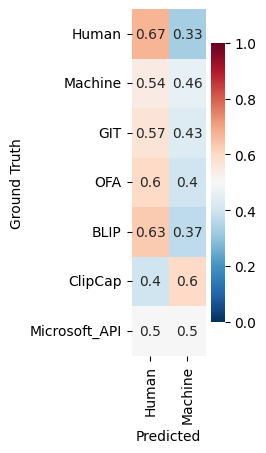

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


mean
[0.5649999976158142, 0.550000011920929, 0.5350000262260437, 0.5199999809265137, 0.6349999904632568, 0.5850000381469727]
std
[0.005006539943939251, 0.012926237383681522, 0.01329125443330361, 0.012748669694073348, 0.012591543492238512, 0.012925930755479506]


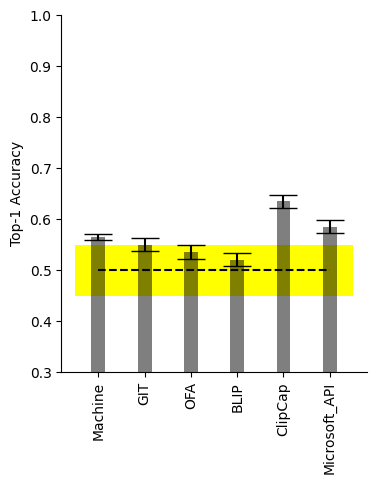

['git', 'ofa', 'blip', 'clipcap', 'microsoft_api']
bootstraptime 6000 sampletime 3000
bootstraptime 1200 sampletime 600
bootstraptime 1200 sampletime 600
bootstraptime 1200 sampletime 600
bootstraptime 1200 sampletime 600
bootstraptime 1200 sampletime 600


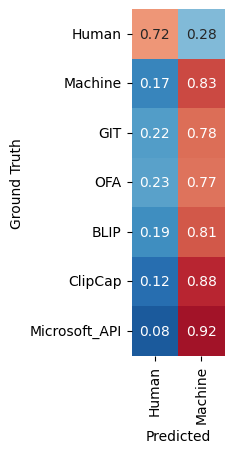

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


mean
[0.7749999761581421, 0.75, 0.7450000047683716, 0.7649999856948853, 0.800000011920929, 0.8200000524520874]
std
[0.003746052102024243, 0.010408753939104084, 0.010488124323851322, 0.010334578194691418, 0.009672650780879975, 0.009599410728924595]


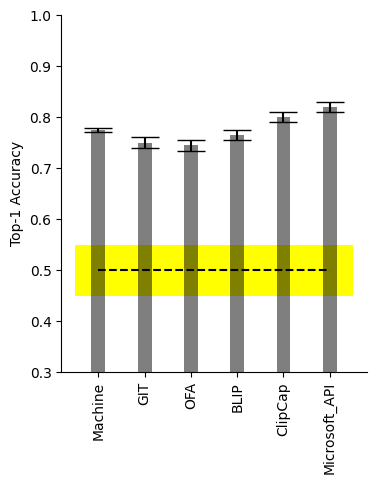

In [ ]:
def plot_res_demographics_singleplot(condition_chosen, TextFilePath, condition_results, folderpath, saveflag):

    top1, top1std, result_conf_mat, dummy = ComputeBarStdConfMat(condition_results[condition_chosen])

    modelist = ['Human', 'Machine', 'GIT', 'OFA', 'BLIP', 'ClipCap', 'Microsoft_API']
    df_cm = pd.DataFrame(result_conf_mat, index = [i for i in modelist],
                  columns = [i for i in ['Human','Machine']])
    plt.figure(figsize = (1.2,4.5))

    if condition_chosen == 'machine':
        sn.heatmap(df_cm, annot=True,robust=True, cmap='RdBu_r', vmin=0, vmax=1, cbar=False)
    else:
        sn.heatmap(df_cm, annot=True,robust=True, cmap='RdBu_r', vmin=0, vmax=1)

    plt.xlabel("Predicted")
    plt.ylabel("Ground Truth")

    plotname = condition_chosen
    plt.savefig(folderpath + plotname + '_overall_confmat.eps', format='eps', bbox_inches='tight')
    plt.savefig(folderpath + plotname + '_overall_confmat.png', bbox_inches='tight')
    plt.show()

    if saveflag == 1:
        np.save(TextFilePath + "confmat.np", result_conf_mat)

    #data
    #x-axis
    years = list(range(1, len(modelist)-1))
    strtask = modelist[1:]
    #print(years)
    #print(strtask)

    # Figure Size
    fig, ax = plt.subplots()

    ax.add_patch(Rectangle((-0.5, 0.45), len(modelist)-1, 0.1,facecolor='yellow'))
    #bar chart properties
    #ax.bar(strtask, top1, color ='black', width = 0.3)
    ax.bar(strtask, top1, yerr=top1std,
       align='center', alpha=0.5, ecolor='black', capsize=10,
       color ='black', width = 0.3)

    print('mean')
    print(top1)
    print('std')
    print(top1std)

    plt.ylabel('Top-1 Accuracy')
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees

    plt.ylim(0.3, 1)
    #plt.xlim(0.5, len(years)+0.5)

    #draw chance 0.5
    chancex =np.arange(len(years)+1)
    plt.plot(chancex, np.arange(len(chancex))*0+0.5, 'k--', label='chance (50%)')
    #plt.legend()

    fig.tight_layout()

    fig.set_figwidth(3.5)
    fig.set_figheight(5)

    #fig.legend(loc='upper center', bbox_to_anchor=(0.55, 1.0), ncol=3, fancybox=True, shadow=True,frameon=False)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.savefig(folderpath + plotname + '_overall_barplot.eps', format='eps', bbox_inches='tight')
    plt.savefig(folderpath + plotname + '_overall_barplot.png', bbox_inches='tight')
    plt.show()



#======================Plot overall results (human judges)=======
with open("./savedResults/compiled.json", 'r') as f:
    CompiledResults = json.load(f)

key = 'combined' #choose from these choices: inlab, mturk
TextFilePath = './savedResults/Task1_' + key + '_' #not being used
folderpath = './plots/Task1_' + key + '_' #for saving the plots
saveflag = 1 #save confmat for final plots
plot_res_demographics_singleplot(key, TextFilePath, CompiledResults, folderpath, saveflag)

#======================Plot overall results (AI judges)=======
with open("./savedResults/compiled.json", 'r') as f:
    CompiledResults = json.load(f)

key = 'machine' #choose from these choices: inlab, mturk
TextFilePath = './savedResults/Task1_' + key + '_' #not being used
folderpath = './plots/Task1_' + key + '_' #for saving the plots
saveflag = 1
plot_res_demographics_singleplot(key, TextFilePath, CompiledResults, folderpath, saveflag)
